# e-Commerce Customer Clustering

In [1]:
# RFM: Recency, Frequency, Monetary Value
# YBR: Your Banking Requirement
# KYC: Know your Customer

# Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn
import scipy
import time
import datetime as dt

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

# Import the Dataset

In [3]:
# Import the Dataset
dataset = pd.read_csv('E-com_Data.csv', sep = ',')
dataset.head(3)

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,29-10-2017,6,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,05-10-2017,2,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,12-10-2017,2,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN


In [4]:
dataset.info()

# 'Cancelled_status', 'Reason for return' and 'Sold as set' has few or no values. Hence drop them
# 'Price' = Quantity * per unit price. Hence drop Quantity and per unit price
# 'Time' can be dropped as it's irrelevant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537979 entries, 0 to 537978
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         404189 non-null  float64
 1   Item Code          537979 non-null  object 
 2   InvoieNo           537979 non-null  int64  
 3   Date of purchase   537979 non-null  object 
 4   Quantity           537979 non-null  int64  
 5   Time               537979 non-null  object 
 6   price per Unit     537979 non-null  float64
 7   Price              537979 non-null  float64
 8   Shipping Location  537979 non-null  object 
 9   Cancelled_status   8345 non-null    object 
 10  Reason of return   3 non-null       object 
 11  Sold as set        0 non-null       float64
dtypes: float64(4), int64(2), object(6)
memory usage: 49.3+ MB


In [5]:
dataset.nunique()

CustomerID            4349
Item Code             4009
InvoieNo             24928
Date of purchase       381
Quantity               462
Time                   770
price per Unit        2900
Price                13529
Shipping Location       20
Cancelled_status         1
Reason of return         2
Sold as set              0
dtype: int64

In [6]:
# Percentage of Missing Data:
dataset.isnull().sum()/len(dataset)*100

# Insights: Customer ID has ~25% missing values. Hence drop the missing values (rows) with consent from Business
# Do not impute the missing values without consent from Business

CustomerID            24.869000
Item Code              0.000000
InvoieNo               0.000000
Date of purchase       0.000000
Quantity               0.000000
Time                   0.000000
price per Unit         0.000000
Price                  0.000000
Shipping Location      0.000000
Cancelled_status      98.448824
Reason of return      99.999442
Sold as set          100.000000
dtype: float64

In [7]:
dataset.duplicated().sum()

9

In [8]:
dataset = dataset.rename(columns = {'InvoieNo' : 'InvoiceNo', 
                                    'Date of purchase' : 'Date'})

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537979 entries, 0 to 537978
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         404189 non-null  float64
 1   Item Code          537979 non-null  object 
 2   InvoiceNo          537979 non-null  int64  
 3   Date               537979 non-null  object 
 4   Quantity           537979 non-null  int64  
 5   Time               537979 non-null  object 
 6   price per Unit     537979 non-null  float64
 7   Price              537979 non-null  float64
 8   Shipping Location  537979 non-null  object 
 9   Cancelled_status   8345 non-null    object 
 10  Reason of return   3 non-null       object 
 11  Sold as set        0 non-null       float64
dtypes: float64(4), int64(2), object(6)
memory usage: 49.3+ MB


In [10]:
# Note: Check with your stakeholder as well as Change Management Team
# If we need to drop:

dataset = dataset.drop_duplicates(ignore_index = True)

In [11]:
dataset.isnull().sum()

CustomerID           133789
Item Code                 0
InvoiceNo                 0
Date                      0
Quantity                  0
Time                      0
price per Unit            0
Price                     0
Shipping Location         0
Cancelled_status     529625
Reason of return     537967
Sold as set          537970
dtype: int64

In [12]:
# Drop Missing Values in column 'CustomerID'

dataset = dataset.dropna(subset = ['CustomerID'])

In [13]:
dataset.isnull().sum()

CustomerID                0
Item Code                 0
InvoiceNo                 0
Date                      0
Quantity                  0
Time                      0
price per Unit            0
Price                     0
Shipping Location         0
Cancelled_status     395998
Reason of return     404181
Sold as set          404181
dtype: int64

In [14]:
dataset.head(50)

,CustomerID,Item Code,InvoiceNo,Date,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,29-10-2017,6,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,05-10-2017,2,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,12-10-2017,2,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,22-08-2017,3,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,10-10-2017,2,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN
5,4349.0,14618,397122,27-10-2017,1,12:43:00 PM,256.0,256.0,Location 1,NaN,NaN,NaN
6,4343.0,15364,368432,13-02-2017,-4,2:46:00 PM,922.0,-3688.0,Location 1,True,NaN,NaN
7,4341.0,85014B,377109,14-05-2017,3,9:22:00 AM,677.0,2031.0,Location 1,NaN,NaN,NaN
8,4341.0,85014A,377109,12-05-2017,3,9:22:00 AM,692.0,2076.0,Location 1,NaN,NaN,NaN
9,4341.0,85014B,390217,07-09-2017,6,2:47:00 PM,670.0,4020.0,Location 1,NaN,NaN,NaN


In [15]:
# Convert Date into proper Date Format 
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.head()

,CustomerID,Item Code,InvoiceNo,Date,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,2017-10-29,6,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,2017-05-10,2,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,2017-12-10,2,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,2017-08-22,3,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,2017-10-10,2,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN


In [16]:
# Creating one more date column for later use
dataset['Date1'] = dataset['Date']
dataset.head()

,CustomerID,Item Code,InvoiceNo,Date,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set,Date1
0,4355.0,15734,398177,2017-10-29,6,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN,2017-10-29
1,4352.0,14616,394422,2017-05-10,2,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN,2017-05-10
2,4352.0,14614,394422,2017-12-10,2,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN,2017-12-10
3,4352.0,85014B,388633,2017-08-22,3,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN,2017-08-22
4,4352.0,15364,394422,2017-10-10,2,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN,2017-10-10


In [17]:
dataset['Date1'].describe()

count                  404181
unique                    381
top       2017-11-24 00:00:00
freq                     2522
first     2016-02-12 00:00:00
last      2017-12-19 00:00:00
Name: Date1, dtype: object

In [18]:
# RFM Method:
# Recency = Latest Date - Last Invoice Date
# Frequency = Count of Invoice No of Transaction(s)
# Monetary = Sum of Total Price per customer

# Prime customers are:
# R: Latest
# F: Very High
# M: Very High

latest_date = dt.datetime(2017,12,20)

In [19]:
RFMScores = dataset.groupby('CustomerID').agg({'Date1' : lambda x:(latest_date - x.max()).days,
                                               'Date'  : lambda x:x.nunique(),
                                               'Price' : lambda x:x.sum()})

# Convert Invoice Date into int
RFMScores['Date'] = RFMScores['Date'].astype(int)

# Rename Column names as Recency, Frequency, Monetory
RFMScores.rename(columns = {'Date1' : 'Recency',
                            'Date'  : 'Frequency',
                            'Price' : 'Monetary'}, inplace = True)

RFMScores.reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary
0,2.0,4,63,553704.0
1,3.0,77,18,257404.0
2,4.0,20,10,176613.0
3,5.0,18,7,41976.0
4,6.0,9,42,151822.0
5,7.0,208,4,9410.0
6,8.0,234,10,135550.0
7,9.0,15,7,65832.0
8,10.0,16,22,331601.0
9,11.0,9,10,771439.0


In [20]:
RFMScores

,Recency,Frequency,Monetary
CustomerID,,,
2.0,4,63,553704.0
3.0,77,18,257404.0
4.0,20,10,176613.0
5.0,18,7,41976.0
6.0,9,42,151822.0
...,...,...,...
4368.0,17,7,20480.0
4369.0,181,6,10774.0
4370.0,12,11,24962.0


In [21]:
RFMScores.Recency.describe()

count    4349.000000
mean       61.445160
std        89.656941
min         1.000000
25%        10.000000
50%        19.000000
75%        73.000000
max       617.000000
Name: Recency, dtype: float64

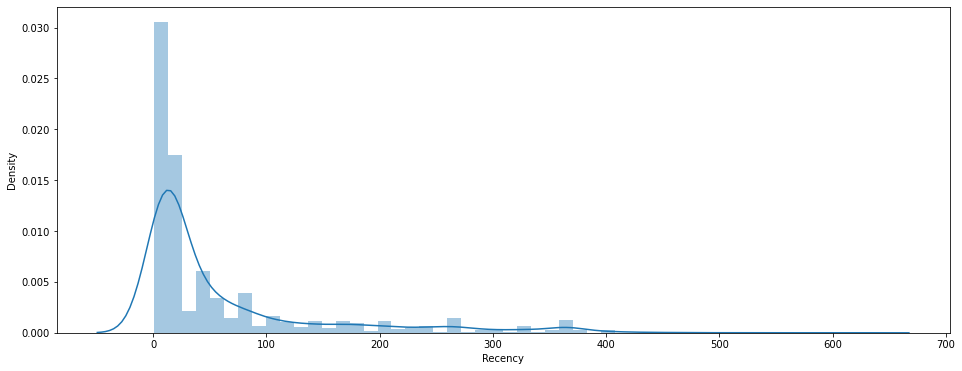

In [22]:
x = RFMScores['Recency']
ax = sns.distplot(x)
# Insights: Recency data is skewed towards the right

In [23]:
RFMScores.Frequency.describe()

count    4349.000000
mean       27.396643
std        33.594882
min         1.000000
25%         9.000000
50%        16.000000
75%        33.000000
max       378.000000
Name: Frequency, dtype: float64

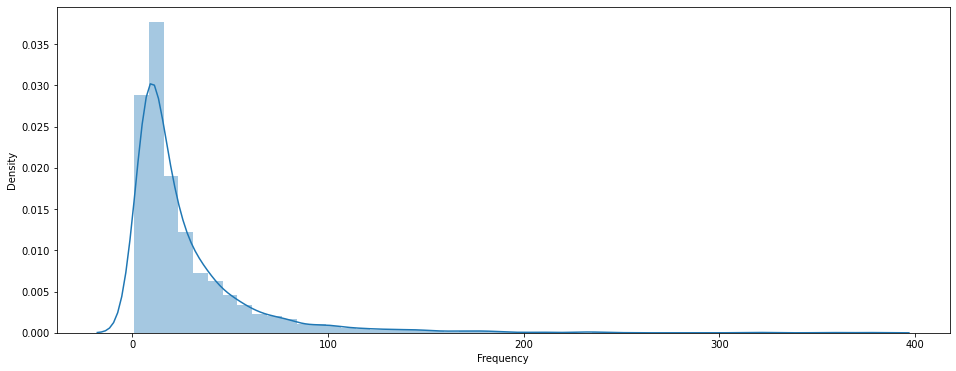

In [24]:
x = RFMScores['Frequency']
ax = sns.distplot(x)
# Insights: Frequency data is skewed towards the right

In [25]:
RFMScores.Monetary.describe()

count    4.349000e+03
mean     2.299380e+05
std      8.572589e+05
min     -5.037200e+04
25%      3.814800e+04
50%      8.365500e+04
75%      2.056120e+05
max      3.553619e+07
Name: Monetary, dtype: float64

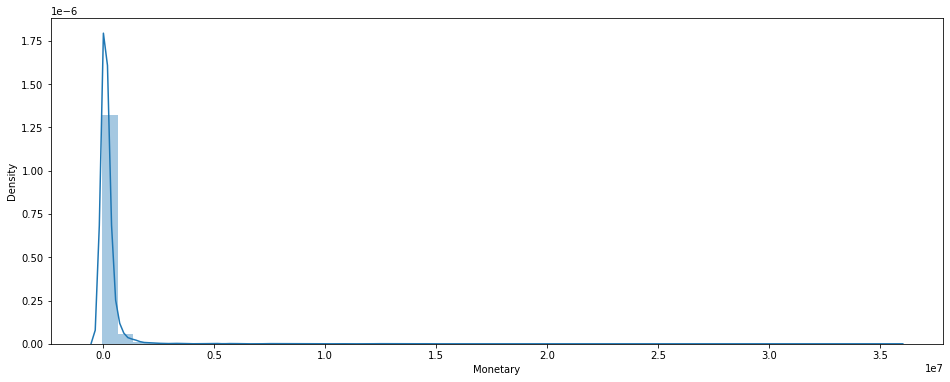

In [26]:
x = RFMScores['Monetary']
ax = sns.distplot(x)
# Insights: Monetary data is Left Skewed

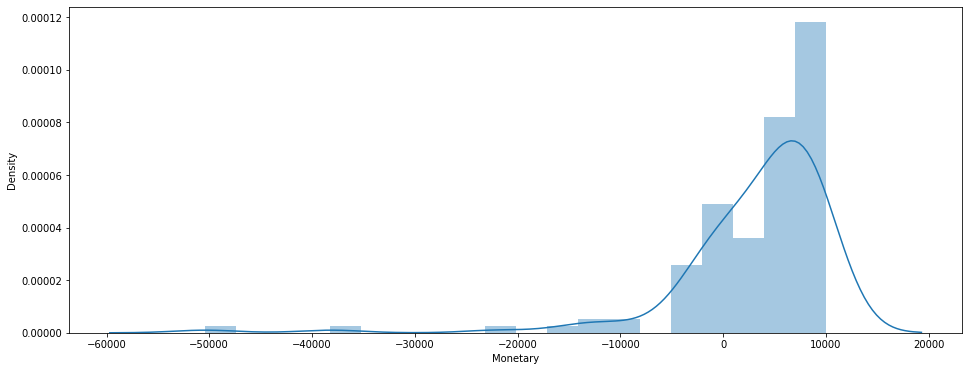

In [27]:
x = RFMScores.query('Monetary < 10000')['Monetary']
ax = sns.distplot(x)

In [28]:
# Split the data into 4 segments, on the basis of quantile or percentile

quantiles = RFMScores.quantile(q = [0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

In [29]:
quantiles

{'Recency': {0.25: 10.0, 0.5: 19.0, 0.75: 73.0},
 'Frequency': {0.25: 9.0, 0.5: 16.0, 0.75: 33.0},
 'Monetary': {0.25: 38148.0, 0.5: 83655.0, 0.75: 205612.0}}

In [30]:
# Functions to create Recency, Frequency and Monetary Segments as 1, 2, 3, 4 based on the above percentiles:

# Recency
def RScores(x, p, d):                # d = dictionary (quantiles), p = percentiles
    if x <= d[p][0.25]:
        return 1    
    elif x <= d[p][0.50]:
        return 2    
    elif x <= d[p][0.75]:
        return 3    
    else:
        return 4

# Frequency & Monetary
def FScores(x, p, d):                # d = dictionary (quantiles), p = percentiles
    if x <= d[p][0.25]:
        return 4    
    elif x <= d[p][0.50]:
        return 3    
    elif x <= d[p][0.75]:
        return 2    
    else:
        return 1

In [31]:
RFMScores['R'] = RFMScores['Recency'].apply(RScores, args=('Recency', quantiles))
RFMScores['F'] = RFMScores['Frequency'].apply(FScores, args=('Frequency', quantiles))
RFMScores['M'] = RFMScores['Monetary'].apply(FScores, args=('Monetary', quantiles))

In [32]:
RFMScores.head(10)

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
2.0,4,63,553704.0,1,1,1
3.0,77,18,257404.0,4,2,1
4.0,20,10,176613.0,3,3,2
5.0,18,7,41976.0,2,4,3
6.0,9,42,151822.0,1,1,2
7.0,208,4,9410.0,4,4,4
8.0,234,10,135550.0,4,3,2
9.0,15,7,65832.0,2,4,3
10.0,16,22,331601.0,2,2,1


In [33]:
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
2.0,4,63,553704.0,1,1,1,111,3
3.0,77,18,257404.0,4,2,1,421,7
4.0,20,10,176613.0,3,3,2,332,8
5.0,18,7,41976.0,2,4,3,243,9
6.0,9,42,151822.0,1,1,2,112,4


In [34]:
# Define 4 labels based on RFM Scores:

loyalty_level = ['Diamond', 'Platinum', 'Gold', 'Silver']
score_cuts = pd.qcut(RFMScores.RFMScore, q=4, labels = loyalty_level)
RFMScores['RFM_loyalty_level'] = score_cuts.values
RFMScores.reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level
0,2.0,4,63,553704.0,1,1,1,111,3,Diamond
1,3.0,77,18,257404.0,4,2,1,421,7,Platinum
2,4.0,20,10,176613.0,3,3,2,332,8,Platinum
3,5.0,18,7,41976.0,2,4,3,243,9,Gold
4,6.0,9,42,151822.0,1,1,2,112,4,Diamond
5,7.0,208,4,9410.0,4,4,4,444,12,Silver
6,8.0,234,10,135550.0,4,3,2,432,9,Gold
7,9.0,15,7,65832.0,2,4,3,243,9,Gold
8,10.0,16,22,331601.0,2,2,1,221,5,Diamond
9,11.0,9,10,771439.0,1,3,1,131,5,Diamond


In [35]:
# Filter RFMGroup = 111 (best customers) and sort them in descending order of Monetary Values

RFMScores[RFMScores['RFMGroup'] == '111'].sort_values('Monetary', ascending = False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level
0,1704.0,3,235,35536194.0,1,1,1,111,3,Diamond
1,1896.0,2,356,17743855.0,1,1,1,111,3,Diamond
2,56.0,10,108,14357682.0,1,1,1,111,3,Diamond
3,1346.0,9,237,12647317.0,1,1,1,111,3,Diamond
4,3802.0,3,236,12319439.0,1,1,1,111,3,Diamond
5,4234.0,3,94,10654918.0,1,1,1,111,3,Diamond
6,1006.0,5,211,9351019.0,1,1,1,111,3,Diamond
7,3203.0,5,99,8102167.0,1,1,1,111,3,Diamond
8,2193.0,1,357,7966054.0,1,1,1,111,3,Diamond
9,1448.0,5,190,7892625.0,1,1,1,111,3,Diamond


In [36]:
RFMScores = RFMScores.reset_index()

In [37]:
RFMScores1 = RFMScores.iloc[:, 1:4]

In [38]:
RFMScores1.head()

,Recency,Frequency,Monetary
0,4,63,553704.0
1,77,18,257404.0
2,20,10,176613.0
3,18,7,41976.0
4,9,42,151822.0


In [39]:
# Feature Scaling / Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
RFMScores1 = scaler.fit_transform(RFMScores1)

# K-Means Cluster

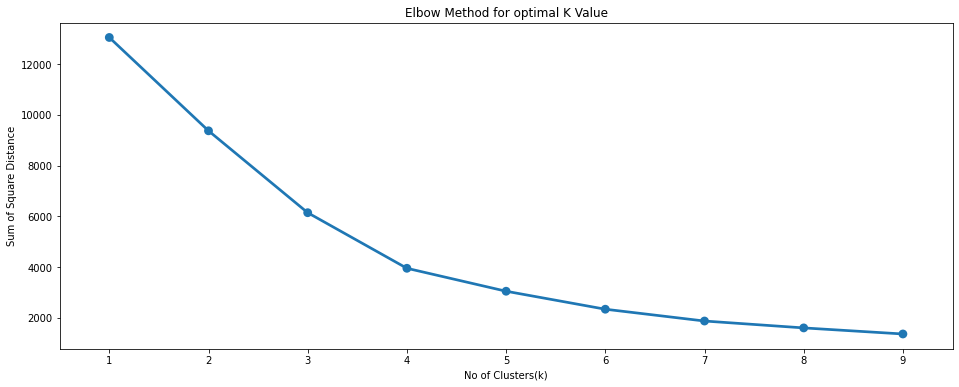

In [40]:
from sklearn.cluster import KMeans

sum_of_square_dist = {}

for k in range(1, 10):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 500)
    km = km.fit(RFMScores1)
    sum_of_square_dist[k] = km.inertia_
    
sns.pointplot(x = list(sum_of_square_dist.keys()), y = list(sum_of_square_dist.values()))
plt.xlabel("No of Clusters(k)")
plt.ylabel("Sum of Square Distance")
plt.title("Elbow Method for optimal K Value")
plt.show()


In [41]:
# Optimal k value is ~4. It can also be taken as 3, 4, 5, 6 based on our choice

kmeans_cluster = km = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 500)
kmeans_cluster.fit(RFMScores1)

KMeans(max_iter=500, n_clusters=6)

In [42]:
RFMScores['Cluster'] = kmeans_cluster.labels_
RFMScores.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level,Cluster
0,2.0,4,63,553704.0,1,1,1,111,3,Diamond,4
1,3.0,77,18,257404.0,4,2,1,421,7,Platinum,1
2,4.0,20,10,176613.0,3,3,2,332,8,Platinum,1
3,5.0,18,7,41976.0,2,4,3,243,9,Gold,1
4,6.0,9,42,151822.0,1,1,2,112,4,Diamond,4
5,7.0,208,4,9410.0,4,4,4,444,12,Silver,0
6,8.0,234,10,135550.0,4,3,2,432,9,Gold,0
7,9.0,15,7,65832.0,2,4,3,243,9,Gold,1
8,10.0,16,22,331601.0,2,2,1,221,5,Diamond,1
9,11.0,9,10,771439.0,1,3,1,131,5,Diamond,1


In [43]:
RFMScores.to_csv('new_cluster_data.csv')